In [1]:
import sys
sys.path.append('/nfs/stak/users/sumons/HP-OSU-Capstone-2023-2024-dev/')

In [2]:
import torch
import matplotlib.pyplot as plt
import os

from config.config import train_val_ratio, target
from dataloader.load_data import load_dataloader
from utils.save_load_model import save
from utils.metrics import binary_iou
from utils.convert import convertBinary

from config.args import get_arguments
from config.config import features,labels,duplex_labels,train_test_ratio,label_extension,threshold,random
from dataloader.load_data import SimplexDataset, DuplexDataset, InputSimplexDataset, InputDuplexDataset
from utils.load_json import load_results
from utils.save_load_model import load
from utils.convert import convertBinary


import logging
import os
import torch
import json
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import random_split, DataLoader, Subset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models.segmentation as segmentation

In [3]:
import os
import torch
import numpy as np
from PIL import Image
# import albumentations as A
from torch.utils.data import Dataset , DataLoader
# from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

In [4]:
class Atrous_Convolution(nn.Module):
    """
  Compute Atrous/Dilated Convolution.
    """

    def __init__(
            self, input_channels, kernel_size, pad, dilation_rate,
            output_channels=256):
        super(Atrous_Convolution, self).__init__()

        self.conv = nn.Conv2d(in_channels=input_channels,
                              out_channels=output_channels,
                              kernel_size=kernel_size, padding=pad,
                              dilation=dilation_rate, bias=False)

        self.batchnorm = nn.BatchNorm2d(output_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

In [5]:
class ASSP(nn.Module):
    """
   Encoder of DeepLabv3+.
    """

    def __init__(self, in_channles, out_channles):
        """Atrous Spatial Pyramid pooling layer
        Args:
            in_channles (int): No of input channel for Atrous_Convolution.
            out_channles (int): No of output channel for Atrous_Convolution.
        """
        super(ASSP, self).__init__()
        self.conv_1x1 = Atrous_Convolution(
            input_channels=in_channles, output_channels=out_channles,
            kernel_size=1, pad=0, dilation_rate=1)

        self.conv_6x6 = Atrous_Convolution(
            input_channels=in_channles, output_channels=out_channles,
            kernel_size=3, pad=6, dilation_rate=6)

        self.conv_12x12 = Atrous_Convolution(
            input_channels=in_channles, output_channels=out_channles,
            kernel_size=3, pad=12, dilation_rate=12)

        self.conv_18x18 = Atrous_Convolution(
            input_channels=in_channles, output_channels=out_channles,
            kernel_size=3, pad=18, dilation_rate=18)

        self.image_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(
                in_channels=in_channles, out_channels=out_channles,
                kernel_size=1, stride=1, padding=0, dilation=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))

        self.final_conv = Atrous_Convolution(
            input_channels=out_channles * 5, output_channels=out_channles,
            kernel_size=1, pad=0, dilation_rate=1)

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_6x6 = self.conv_6x6(x)
        x_12x12 = self.conv_12x12(x)
        x_18x18 = self.conv_18x18(x)
        img_pool_opt = self.image_pool(x)
        img_pool_opt = F.interpolate(
            img_pool_opt, size=x_18x18.size()[2:],
            mode='bilinear', align_corners=True)
    # concatination of all features
        concat = torch.cat(
            (x_1x1, x_6x6, x_12x12, x_18x18, img_pool_opt),
            dim=1)
        x_final_conv = self.final_conv(concat)
        return x_final_conv

In [6]:
class ResNet_50(nn.Module):
    def __init__(self, output_layer=None):
        super(ResNet_50, self).__init__()
        self.pretrained = torchvision.models.resnet50(pretrained=False)
        self.output_layer = output_layer

        original_first_layer = self.pretrained.conv1
        # Create a new Conv2d layer with 10 input channels instead of 3 but same output channels and kernel size
        self.pretrained.conv1 = nn.Conv2d(10, original_first_layer.out_channels,
                                          kernel_size=original_first_layer.kernel_size,
                                          stride=original_first_layer.stride,
                                          padding=original_first_layer.padding,
                                          bias=original_first_layer.bias)
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1, len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])
        self.net = nn.Sequential(self.pretrained._modules)
        self.pretrained = None

    def forward(self, x):
        x = self.net(x)
        return x

In [7]:
class Deeplabv3Plus(nn.Module):
    def __init__(self, num_classes):

        super(Deeplabv3Plus, self).__init__()

        self.backbone = ResNet_50(output_layer='layer3')

        self.low_level_features = ResNet_50(output_layer='layer1')

        self.assp = ASSP(in_channles=1024, out_channles=256)

        self.conv1x1 = Atrous_Convolution(
            input_channels=256, output_channels=48, kernel_size=1,
            dilation_rate=1, pad=0)

        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.classifer = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):

        x_backbone = self.backbone(x)
        x_low_level = self.low_level_features(x)
        x_assp = self.assp(x_backbone)
        x_assp_upsampled = F.interpolate(
            x_assp, scale_factor=(4, 4),
            mode='bilinear', align_corners=True)
        x_conv1x1 = self.conv1x1(x_low_level)
        x_assp_upsampled = F.interpolate(x_assp_upsampled, size=(75, 75), mode='bilinear', align_corners=False)
        # print(x_conv1x1.size())
        # print(x_assp_upsampled.size())
        x_cat = torch.cat([x_conv1x1, x_assp_upsampled], dim=1)
        x_3x3 = self.conv_3x3(x_cat)
        x_3x3_upscaled = F.interpolate(
            x_3x3, scale_factor=(4, 4),
            mode='bilinear', align_corners=True)
        x_out = self.classifer(x_3x3_upscaled)
        # x_out = torch.sigmoid(x_out)
        return x_out

In [8]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_losss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):

        BCE = self.bce_losss(inputs, targets)

        inputs = torch.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(
            inputs.sum() + targets.sum() + smooth)
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [9]:
class IOU(nn.Module):

    def __init__(self, weight=None, size_average=True):
        super(IOU, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # intersection is equivalent to True Positive count
        # union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return IoU

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [21]:
model = Deeplabv3Plus(num_classes=8).to(device)
model = nn.DataParallel(model)
model_path = '/nfs/hpc/share/sumons/working_folder/saved_models/duplex_deeplabv3+.pth'
model.load_state_dict(torch.load(model_path))


input_tensor = torch.randn(4, 10, 300, 300)
output = model(input_tensor)

print(output.shape)

torch.Size([4, 8, 300, 300])


In [14]:
label_folder = '/nfs/hpc/share/sumons/working_folder/Data/Output'
input_folder = '/nfs/hpc/share/sumons/working_folder/Data/Input'

In [15]:
pdf,algorithm,intermediate = load_results(label_folder)

In [16]:
dataset = DuplexDataset(input_folder,label_folder,intermediate)

In [17]:
train_dataloader, val_dataloader = load_dataloader(dataset,8,train_val_ratio)

In [22]:
# loss_fn = DiceBCELoss()
criterion = nn.BCELoss().to(device)
iou_fn = IOU()
optimizer = optim.Adam(model.parameters(), lr = 1e-6)

In [24]:
train_iou = []
train_loss = []

for epoch in range(20):
    model.train()
    print(f"Epoch: {epoch+1}/{20}")

    iterations = 0
    iter_loss = 0.0
    iter_iou = 0.0

    # batch_loop = tqdm(train_dataloader)
    
    for batch_data in train_dataloader:
        
        inputs, masks = batch_data[0].to(device), batch_data[1].to(device)
        inputs = inputs/255.0
        predictions = model(inputs)
        predictions_ = torch.sigmoid(predictions)
        # loss = loss_fn(predictions , masks)
        loss = criterion(predictions_, masks)
        
        iou = iou_fn(predictions , masks)
        
        # print(loss.item())
        # print(iou.item())
        
        iter_loss += loss.item()
        iter_iou += iou.item()

        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        

    
    train_loss.append(iter_loss / len(train_dataloader))
    train_iou.append(iter_iou/ len(train_dataloader))
    print(f"Epoch: {epoch+1}/{20}, Training loss: {round(train_loss[-1] , 5)}, IOU: {round(train_iou[-1] , 5)}")
    torch.save(model.state_dict(), '/nfs/hpc/share/sumons/working_folder/saved_models/duplex_deeplabv3+.pth')


Epoch: 1/20
Epoch: 1/20, Training loss: 0.04431, IOU: 0.6887
Epoch: 2/20
Epoch: 2/20, Training loss: 0.04428, IOU: 0.69246
Epoch: 3/20
Epoch: 3/20, Training loss: 0.0443, IOU: 0.68588
Epoch: 4/20
Epoch: 4/20, Training loss: 0.04428, IOU: 0.68908
Epoch: 5/20
Epoch: 5/20, Training loss: 0.04427, IOU: 0.68776
Epoch: 6/20
Epoch: 6/20, Training loss: 0.04429, IOU: 0.69134
Epoch: 7/20
Epoch: 7/20, Training loss: 0.04427, IOU: 0.67962
Epoch: 8/20
Epoch: 8/20, Training loss: 0.04431, IOU: 0.68446
Epoch: 9/20
Epoch: 9/20, Training loss: 0.04431, IOU: 0.68808
Epoch: 10/20
Epoch: 10/20, Training loss: 0.04423, IOU: 0.69041
Epoch: 11/20
Epoch: 11/20, Training loss: 0.04425, IOU: 0.68192
Epoch: 12/20
Epoch: 12/20, Training loss: 0.04423, IOU: 0.68775
Epoch: 13/20
Epoch: 13/20, Training loss: 0.04424, IOU: 0.68446
Epoch: 14/20
Epoch: 14/20, Training loss: 0.04424, IOU: 0.67799
Epoch: 15/20
Epoch: 15/20, Training loss: 0.04423, IOU: 0.68578
Epoch: 16/20
Epoch: 16/20, Training loss: 0.04425, IOU: 0.68

In [53]:
def eval_model():
    output_images = []
    masks_ = []
    model.eval()
    with torch.no_grad():
        for batch_data in val_dataloader:
            inputs, masks = batch_data[0].to(device), batch_data[1].to(device)
            inputs = inputs/255.0
            outputs = model(inputs.float())
            outputs = torch.sigmoid(outputs)
            output_images.append(outputs)
            masks_.append(masks)
    return output_images, masks_

In [54]:
output_images, masks_ = eval_model()

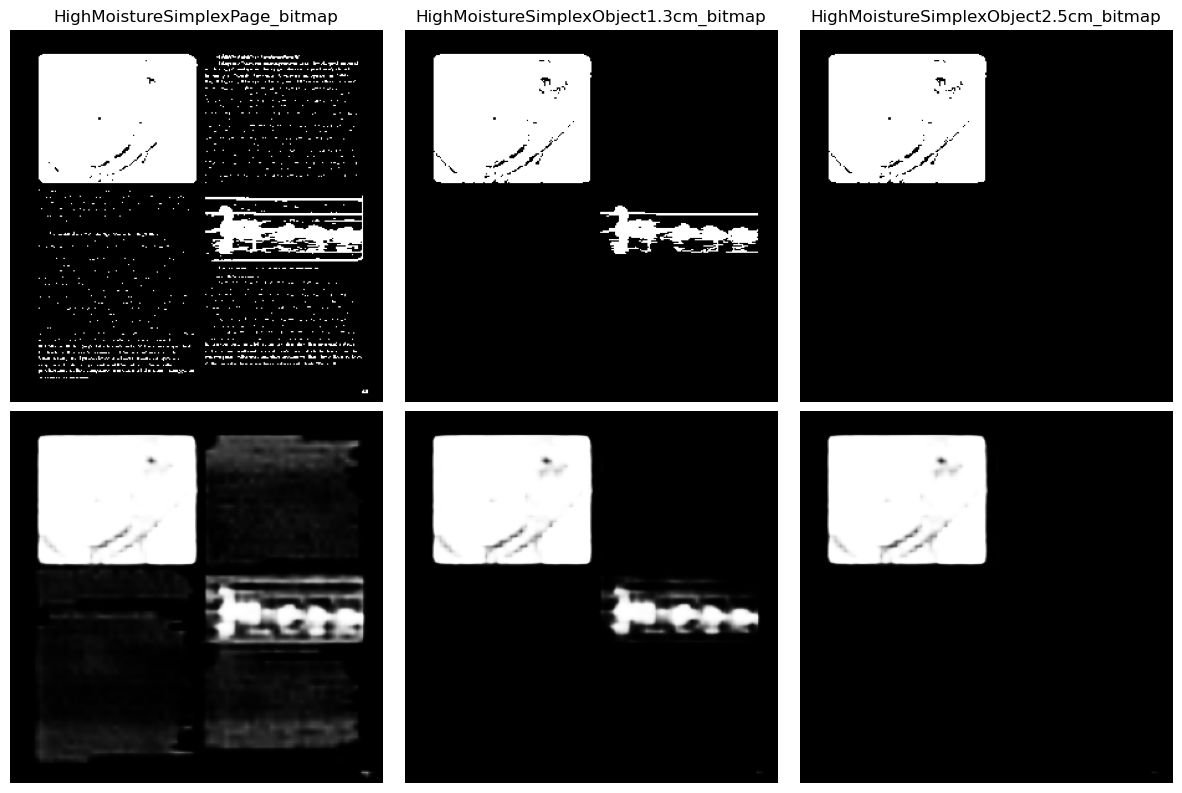

In [56]:
# original output from the model
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

titles = ['HighMoistureSimplexPage_bitmap', 'HighMoistureSimplexObject1.3cm_bitmap', 'HighMoistureSimplexObject2.5cm_bitmap']

index = 3
batch_index = 3
for i in range(3):
    # Display each mask in the first row
    axs[0, i].imshow(masks_[index][batch_index][i].cpu(), cmap='gray')
    axs[0, i].axis('off')  # Hide axes for clarity
    axs[0, i].set_title(titles[i])
    
    
    
    axs[1, i].imshow((output_images[index][batch_index][i]*255.0).cpu(), cmap='gray')
    axs[1, i].axis('off')  # Hide axes for clarity
#     axs[1, i].set_title(titles[i])

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()  # Display the plot

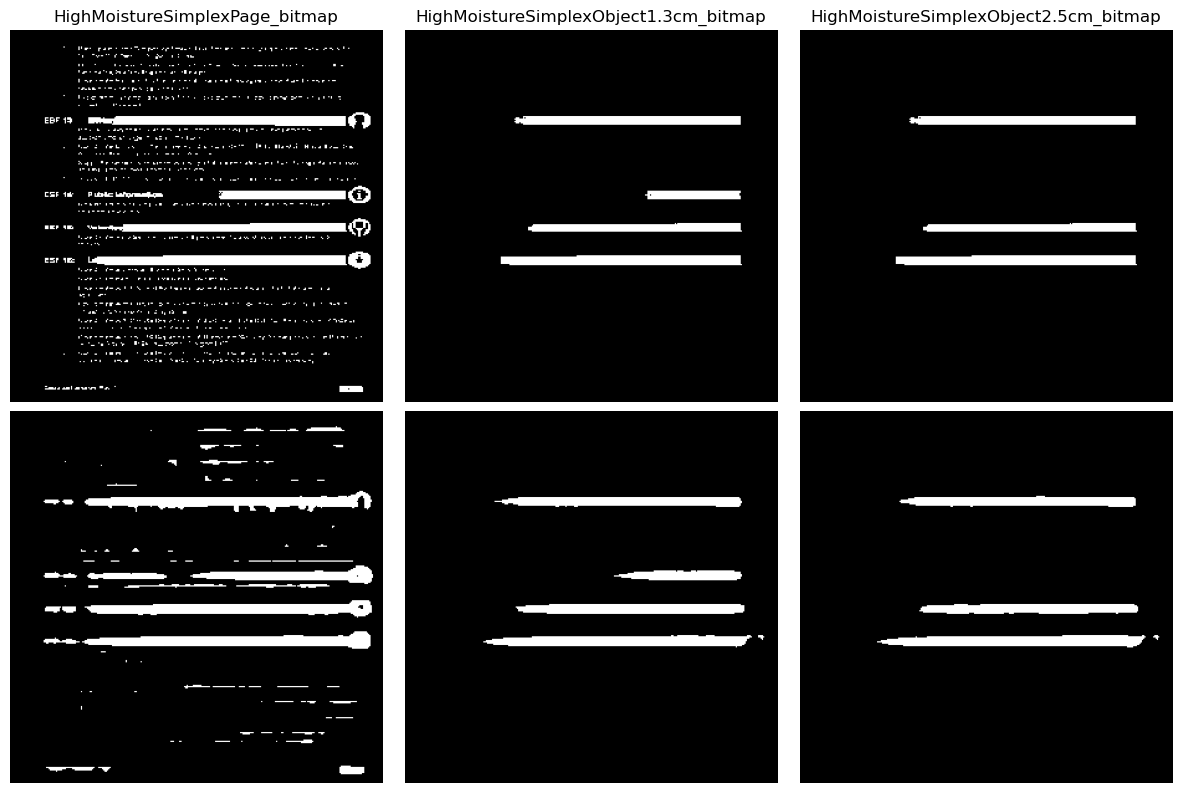

In [75]:
# Manual thresholding
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

titles = ['HighMoistureSimplexPage_bitmap', 'HighMoistureSimplexObject1.3cm_bitmap', 'HighMoistureSimplexObject2.5cm_bitmap']

index = 5
batch_index = 3
for i in range(3):
    # Display each mask in the first row
    axs[0, i].imshow(masks_[index][batch_index][i].cpu(), cmap='gray')
    axs[0, i].axis('off')  # Hide axes for clarity
    axs[0, i].set_title(titles[i])
    
    # Convert outputs to 0 or 1 based on 0.05 threshold before displaying
    # Note: Ensure output_images[index][batch_index][i] is a PyTorch tensor
    thresholded_output = torch.where(output_images[index][batch_index][i] > 0.2, 1.0, 0.0)
    axs[1, i].imshow(thresholded_output.cpu(), cmap='gray')
    axs[1, i].axis('off')  # Hide axes for clarity
    # axs[1, i].set_title(titles[i])

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()  # Display the plot


In [79]:
# Adaptive thresholding

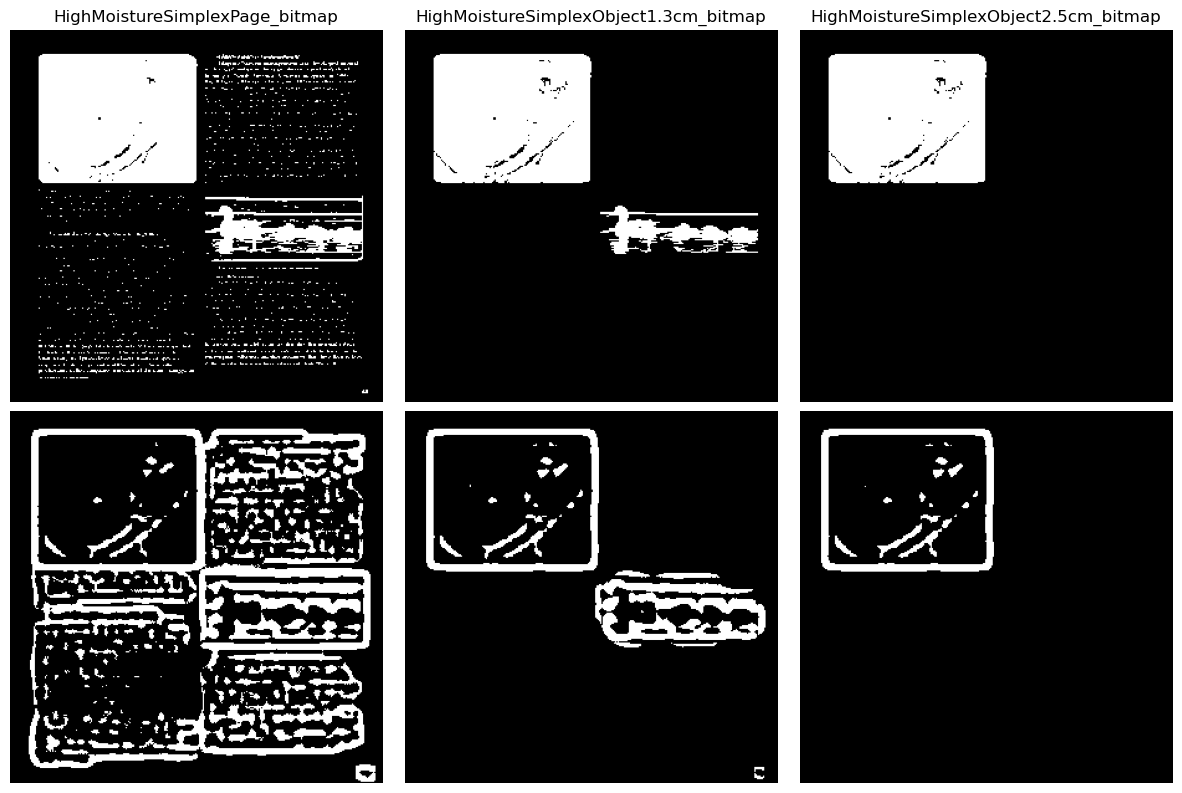

In [77]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

titles = ['HighMoistureSimplexPage_bitmap', 'HighMoistureSimplexObject1.3cm_bitmap', 'HighMoistureSimplexObject2.5cm_bitmap']

index = 3
batch_index = 3
for i in range(3):
    # Display each mask in the first row
    mask_image = masks_[index][batch_index][i].cpu().numpy()
    axs[0, i].imshow(mask_image, cmap='gray')
    axs[0, i].axis('off')  # Hide axes for clarity
    axs[0, i].set_title(titles[i])
    
    # Convert output to NumPy array and apply adaptive thresholding
    output_image = (output_images[index][batch_index][i]*255.0).cpu().numpy().astype(np.uint8)
    
    # Ensure the image is in single-channel format for adaptiveThreshold
    if len(output_image.shape) == 3 and output_image.shape[2] == 3:
        output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding
    adaptive_thresh_image = cv2.adaptiveThreshold(output_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                                   cv2.THRESH_BINARY, 11, 2)
    
    # Optional: Invert the image if needed (uncomment the line below if necessary)
    adaptive_thresh_image = 255 - adaptive_thresh_image
    
    axs[1, i].imshow(adaptive_thresh_image, cmap='gray')
    axs[1, i].axis('off')  # Hide axes for clarity

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()  # Display the plot
